## Урок 2. Домашнее задание

Скопируем решение, представленное на лекции, чтобы далее производить его модификации и сравнить с полученными результатами.

In [251]:
import pandas as pd

from gensim.corpora.dictionary import Dictionary

from sklearn.pipeline import Pipeline

#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

# import nltk
# nltk.download('stopwords')

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

from sklearn.metrics import f1_score, roc_auc_score, precision_score, \
                            classification_report, precision_recall_curve, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

import itertools

%matplotlib inline

In [252]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [253]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [254]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [255]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [256]:
news = pd.read_csv("./lection2_materials/articles.csv")
news.head(3)

,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [257]:
users = pd.read_csv("./lection2_materials/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [258]:
stopword_ru = stopwords.words('russian')

with open('./lection2_materials/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords

morph = pymorphy2.MorphAnalyzer()

In [259]:
%%time
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 27.2 s, sys: 1.46 s, total: 28.7 s
Wall time: 28.8 s


In [260]:
%%time
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 34s, sys: 1.15 s, total: 4min 36s
Wall time: 4min 37s


In [261]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [262]:
%%time
from gensim.models import LdaModel

lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)

CPU times: user 45.7 s, sys: 2.92 s, total: 48.6 s
Wall time: 32.3 s


In [263]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: обнаружить источник тело эксперимент сотрудник данные восток
topic_1: выяснить статья американский автор эксперт дом день
topic_2: сша россия новый цена nn санкция российский
topic_3: взрыв остров солнце nn японский вирус место
topic_4: всё газ большой первый рост новый жизнь
topic_5: запустить форум чёрный разместить мышь сенатор городской
topic_6: украина ребёнок закон nn орган рубль статья
topic_7: экипаж вода катастрофа иск китай флот министерство
topic_8: исследование научный тыс рубль объём ставка около
topic_9: смерть участок торговый предприниматель гражданство греция греческий
topic_10: гражданин памятник парк билет память ресторан артист
topic_11: путин налог белоруссия пресссекретарить украина продолжительность песок
topic_12: эксперт писать гражданин погибнуть помощь всё nn
topic_13: опасаться умереть трансляция столетие соболезнование критиковать занятый
topic_14: свидетель журнал студент остаток орден ii эволюция
topic_15: пациент пенсия технология nn депутат про

In [264]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.000000,0.014870,0.000000,0.00000,0.000000,0.162585,0.0,0.0,...,0.000000,0.000000,0.272464,0.09964,0.0,0.000000,0.393319,0.050072,0.0,0.0
1,4896,0.0,0.053120,0.000000,0.539419,0.00000,0.000000,0.073700,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.311630,0.0,0.0
2,4897,0.0,0.000000,0.000000,0.000000,0.00000,0.217422,0.000000,0.0,0.0,...,0.160749,0.052491,0.064384,0.00000,0.0,0.000000,0.000000,0.376993,0.0,0.0
3,4898,0.0,0.095968,0.000000,0.000000,0.45767,0.000000,0.000000,0.0,0.0,...,0.026450,0.000000,0.000000,0.00000,0.0,0.198107,0.000000,0.128398,0.0,0.0
4,4899,0.0,0.000000,0.622674,0.000000,0.00000,0.000000,0.000000,0.0,0.0,...,0.198255,0.084312,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [265]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [266]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.016610,0.089523,0.104741,0.035755,0.048220,0.000000,0.155533,0.014785,0.044857,...,0.029934,0.012764,0.128392,0.098574,0.022734,0.054483,0.012890,0.000000,0.018554,0.022146
1,u108690,0.018140,0.080367,0.229087,0.007721,0.106385,0.004024,0.097284,0.000000,0.022331,...,0.000000,0.001745,0.079616,0.130171,0.014706,0.019035,0.021737,0.009291,0.000000,0.008503
2,u108339,0.031763,0.078387,0.112445,0.028085,0.050141,0.020985,0.168984,0.004967,0.025362,...,0.003939,0.046680,0.043287,0.182274,0.019704,0.019394,0.006602,0.000000,0.041492,0.009136


In [267]:
target = pd.read_csv("./lection2_materials/users_churn.csv")
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.016610,0.089523,0.104741,0.035755,0.048220,0.000000,0.155533,0.014785,0.044857,...,0.012764,0.128392,0.098574,0.022734,0.054483,0.012890,0.000000,0.018554,0.022146,0
1,u108690,0.018140,0.080367,0.229087,0.007721,0.106385,0.004024,0.097284,0.000000,0.022331,...,0.001745,0.079616,0.130171,0.014706,0.019035,0.021737,0.009291,0.000000,0.008503,1
2,u108339,0.031763,0.078387,0.112445,0.028085,0.050141,0.020985,0.168984,0.004967,0.025362,...,0.046680,0.043287,0.182274,0.019704,0.019394,0.006602,0.000000,0.041492,0.009136,1


In [268]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=42)

In [269]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [270]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.00211568, 0.30230861, 0.05317928, 0.06027468, 0.12440145,
       0.07053243, 0.00885712, 0.35574871, 0.38255563, 0.09080515])

In [271]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test, preds)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
ix_mean = np.argmax(fscore_mean)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_mean[ix_mean], 
                                                                        fscore_mean[ix_mean],
                                                                        precision_mean[ix_mean],
                                                                        recall_mean[ix_mean]))

Best Threshold=0.224442, F-Score=0.695, Precision=0.592, Recall=0.842


Confusion matrix, without normalization
[[1600  147]
 [  41  212]]


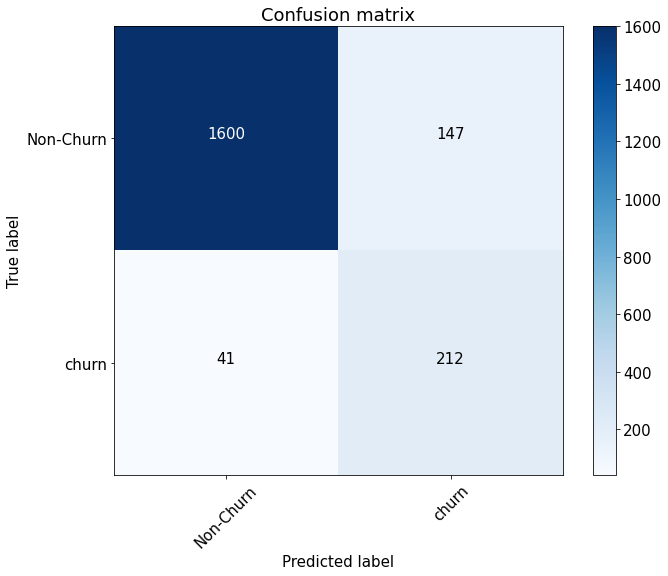

In [272]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds_mean[ix_mean])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_mean.png")
plt.show()

In [273]:
roc_auc_score_mean = roc_auc_score(y_test, preds)
roc_auc_score_mean

0.9499514696000597

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [274]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [275]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.053612,0.067336,0.000000,0.000000,0.000000,0.088369,0.0,0.000000,...,0.014781,0.000000,0.111211,0.067176,0.000000,0.000000,0.000000,0.0,0.009684,0.0
1,u108690,0.000000,0.068717,0.174385,0.000000,0.097650,0.000000,0.076963,0.0,0.008989,...,0.000000,0.000000,0.088045,0.150108,0.000000,0.016274,0.009598,0.0,0.000000,0.0
2,u108339,0.025816,0.034760,0.083765,0.013202,0.038828,0.020135,0.174609,0.0,0.015690,...,0.000000,0.014245,0.026051,0.189323,0.010463,0.012988,0.000000,0.0,0.000000,0.0


In [276]:
target = pd.read_csv("./lection2_materials/users_churn.csv")
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.053612,0.067336,0.000000,0.000000,0.000000,0.088369,0.0,0.000000,...,0.000000,0.111211,0.067176,0.000000,0.000000,0.000000,0.0,0.009684,0.0,0
1,u108690,0.000000,0.068717,0.174385,0.000000,0.097650,0.000000,0.076963,0.0,0.008989,...,0.000000,0.088045,0.150108,0.000000,0.016274,0.009598,0.0,0.000000,0.0,1
2,u108339,0.025816,0.034760,0.083765,0.013202,0.038828,0.020135,0.174609,0.0,0.015690,...,0.014245,0.026051,0.189323,0.010463,0.012988,0.000000,0.0,0.000000,0.0,1


In [277]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=42)

In [278]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [279]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.00134281, 0.21650788, 0.06389809, 0.04355125, 0.10668544,
       0.02760959, 0.00542688, 0.37739695, 0.35053763, 0.06584953])

In [280]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test, preds)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
ix_median = np.argmax(fscore_median)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix_median], 
                                                                        fscore_median[ix_median],
                                                                        precision_median[ix_median],
                                                                        recall_median[ix_median]))

Best Threshold=0.265423, F-Score=0.799, Precision=0.731, Recall=0.881


Confusion matrix, without normalization
[[1665   82]
 [  31  222]]


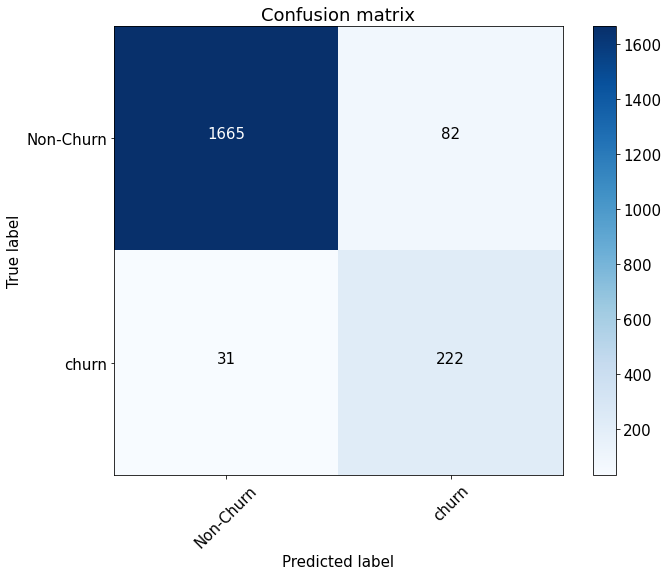

In [281]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds_median[ix_median])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_median.png")
plt.show()

In [282]:
roc_auc_score_median = roc_auc_score(y_test, preds)
roc_auc_score_median

0.9775538415940596

3. Повторить п.2, но используя уже не медиану, а max

In [283]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [284]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.059824,0.339792,0.272624,0.130888,0.202916,0.000000,0.548974,0.088711,0.236041,...,0.107615,0.076585,0.338470,0.267723,0.126214,0.250674,0.077338,0.000000,0.052043,0.103432
1,u108690,0.097771,0.190654,0.547333,0.046328,0.240597,0.012243,0.246349,0.000000,0.094410,...,0.000000,0.010472,0.130146,0.200861,0.064349,0.045185,0.061945,0.055744,0.000000,0.051016
2,u108339,0.085621,0.194280,0.280345,0.076754,0.103377,0.045301,0.298162,0.029803,0.074521,...,0.023634,0.148872,0.117537,0.295249,0.056904,0.051471,0.039610,0.000000,0.233517,0.034988


In [285]:
target = pd.read_csv("./lection2_materials/users_churn.csv")
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.059824,0.339792,0.272624,0.130888,0.202916,0.000000,0.548974,0.088711,0.236041,...,0.076585,0.338470,0.267723,0.126214,0.250674,0.077338,0.000000,0.052043,0.103432,0
1,u108690,0.097771,0.190654,0.547333,0.046328,0.240597,0.012243,0.246349,0.000000,0.094410,...,0.010472,0.130146,0.200861,0.064349,0.045185,0.061945,0.055744,0.000000,0.051016,1
2,u108339,0.085621,0.194280,0.280345,0.076754,0.103377,0.045301,0.298162,0.029803,0.074521,...,0.148872,0.117537,0.295249,0.056904,0.051471,0.039610,0.000000,0.233517,0.034988,1


In [286]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=42)

In [287]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [288]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([4.90410391e-04, 6.26715718e-02, 1.53990080e-01, 5.80768712e-02,
       2.56691010e-02, 2.11479521e-03, 9.54517113e-04, 7.30677577e-02,
       6.78290470e-01, 2.76499995e-02])

In [289]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test, preds)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
ix_max = np.argmax(fscore_max)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix_max], 
                                                                        fscore_max[ix_max],
                                                                        precision_max[ix_max],
                                                                        recall_max[ix_max]))

Best Threshold=0.356368, F-Score=0.824, Precision=0.823, Recall=0.826


Confusion matrix, without normalization
[[1702   45]
 [  45  208]]


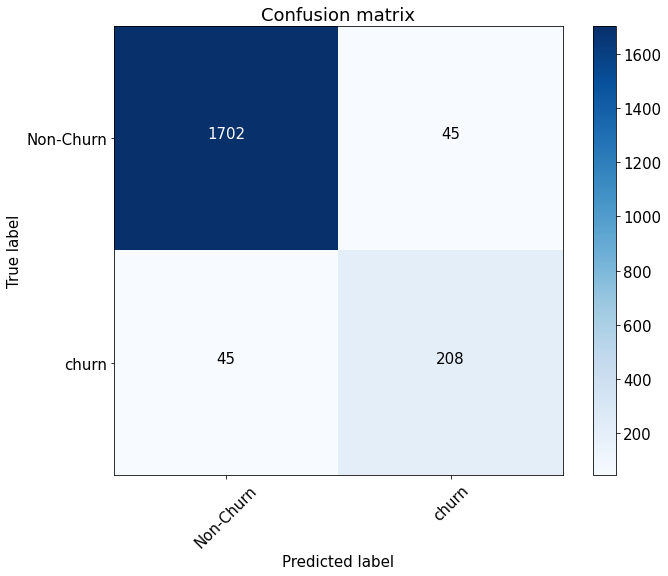

In [290]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds_max[ix_max])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_max.png")
plt.show()

In [291]:
roc_auc_score_max = roc_auc_score(y_test, preds)
roc_auc_score_max

0.9794090829903775

4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

In [292]:
pipeline = Pipeline([('tfidf', TfidfVectorizer()), 
                     ('clf', LogisticRegression())])

In [293]:
target = pd.read_csv("./lection2_materials/users_churn.csv")
X = pd.merge(users, target, 'left')
X.head(3)

,uid,articles,churn
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]",0
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]",1
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]",1


In [294]:
X_train, X_test, y_train, y_test = train_test_split(X['articles'], 
                                                    X['churn'], random_state=42)

In [295]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

In [296]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.09169299, 0.11971181, 0.10071714, 0.12773011, 0.12792365,
       0.08964499, 0.0973546 , 0.10614305, 0.21450289, 0.09056103])

In [297]:
precision_tfidf, recall_tfidf, thresholds_tfidf= precision_recall_curve(y_test, preds)
fscore_tfidf = (2 * precision_tfidf * recall_tfidf) / (precision_tfidf + recall_tfidf)
ix_tfidf = np.argmax(fscore_tfidf)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_tfidf[ix_tfidf], 
                                                                        fscore_tfidf[ix_tfidf],
                                                                        precision_tfidf[ix_tfidf],
                                                                        recall_tfidf[ix_tfidf]))

Best Threshold=0.148068, F-Score=0.897, Precision=0.867, Recall=0.929


Confusion matrix, without normalization
[[1711   36]
 [  19  234]]


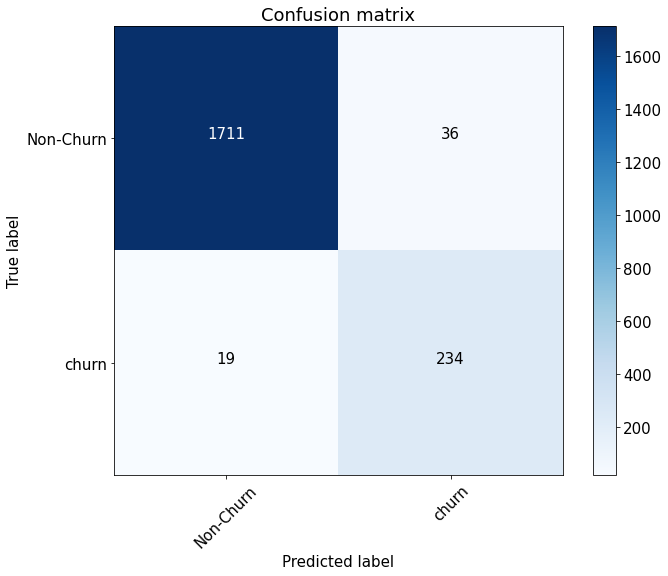

In [298]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds_tfidf[ix_tfidf])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_tfidf.png")
plt.show()

In [299]:
roc_auc_score_tfidf = roc_auc_score(y_test, preds)
roc_auc_score_tfidf

0.9931514442601772

5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных методов получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [300]:
df = pd.DataFrame([['mean', precision_mean[ix_mean], recall_mean[ix_mean], fscore_mean[ix_mean], roc_auc_score_mean], 
                   ['median', precision_median[ix_median], recall_median[ix_median], fscore_median[ix_median], roc_auc_score_median], 
                   ['max', precision_max[ix_max], recall_max[ix_max], fscore_max[ix_max], roc_auc_score_max], 
                   ['tfidf', precision_tfidf[ix_tfidf], recall_tfidf[ix_tfidf], fscore_tfidf[ix_tfidf], roc_auc_score_tfidf]], 
                  columns=['method', 'precision', 'recall', 'fscore', 'roc_auc'])
df

,method,precision,recall,fscore,roc_auc
0,mean,0.591667,0.841897,0.694943,0.949951
1,median,0.731148,0.881423,0.799283,0.977554
2,max,0.822835,0.826087,0.824458,0.979409
3,tfidf,0.867159,0.928854,0.896947,0.993151


6. Сделать самостоятельные выводы и предположения о том, почему тот или иной способ оказался эффективнее остальных

Медианный эмбединг оказывается лучше среднего, на мой взгляд, потому, что меньше подвержен влиянию разброса принадлежности к темам. Лучший результат по большинству метрик достигается на методе с векторизацией id статей. По-видимому эта модель, которая берет статью за единицу информации, лучше улавливает интересы пользователя и связь прочитанных статей с оттоком, чем вероятностная модель LDA. Возможно изменяя гиперпараметры в модели LDA, например количество тем или проведя более глубокий предпроцессинг, можно добиться сравнимых результатов. Кроме того недостатком модели LDA является то, что каждый раз мы получаем новые темы, которые не всегда хорошо интерпретируемы. Это создает дополнительный разброс в результатах модели LDA.